In [1]:
from __future__ import print_function
import cv2 
from os import listdir
import numpy as np

import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import random
import seaborn as sns
import cv2
import os

from pathlib import Path
from keras.utils import to_categorical
from collections import Counter
from plotly.subplots import make_subplots
from keras.layers.experimental import preprocessing as ps
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:


path = Path("/kaggle/input/covid-wwo-pneumonia-chest-xray/Data")
covid_without_PNEUMONIA_train_path = path / 'train' / 'covid_without_PNEUMONIA'
covid_with_PNEUMONIA_train_path = path / 'train' / 'covid_with_PNEUMONIA'

covid_without_PNEUMONIA_test_path = path / 'test' / 'covid_without_PNEUMONIA'
covid_with_PNEUMONIA_test_path = path / 'test' / 'covid_with_PNEUMONIA'


In [3]:
covid_without_PNEUMONIA_path = [covid_without_PNEUMONIA_train_path, covid_without_PNEUMONIA_test_path]
covid_with_PNEUMONIA_path = [covid_with_PNEUMONIA_train_path, covid_with_PNEUMONIA_test_path]

In [ ]:
np.random.seed(42)
random.seed(42)

In [5]:
label2category = {'covid_without_PNEUMONIA': 0, 'covid_with_PNEUMONIA': 1}
category2label = {0: 'covid_without_PNEUMONIA', 1: 'covid_with_PNEUMONIA'}

In [6]:
data = []

for path in covid_without_PNEUMONIA_path:
    for img in path.glob('*.jpeg'):
        data.append({'img_path': str(img), 'label': 'covid_without_PNEUMONIA'})
    
for path in covid_with_PNEUMONIA_path:
    for img in path.glob('*.jpeg'):
        data.append({'img_path': str(img), 'label': 'covid_with_PNEUMONIA'})
        
# np.random.shuffle(data)

In [7]:
def counter_label(data=None, key=None, index=None):
    label = []

    for value in data:
        label.append(value[key])

    return Counter(label)

In [8]:
# counter_df = counter_df(data=data, key='label', index='without_augmentation')
img_l_counter = counter_label(data, 'label')
keys = list(img_l_counter.keys())
values = list(img_l_counter.values())

px.bar(x=keys, y=values, color=keys, width=800, height=400)

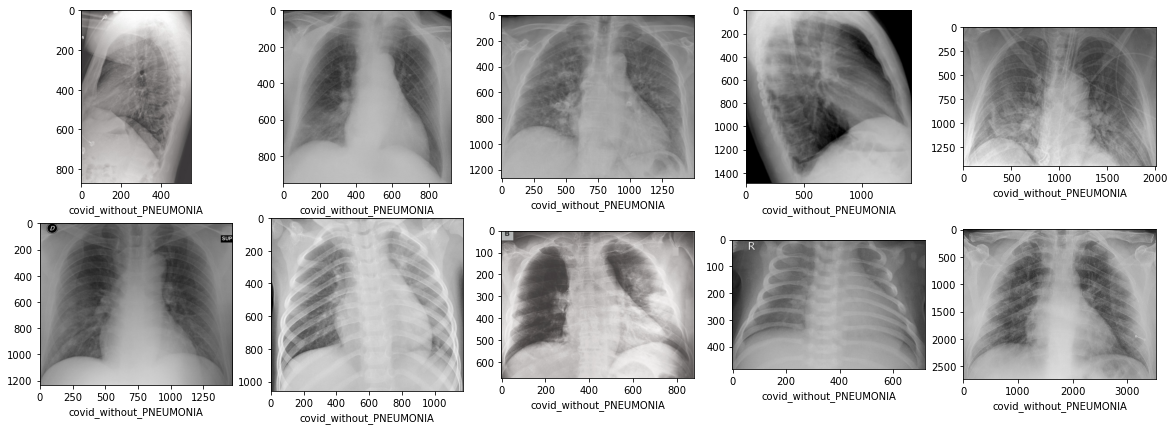

In [9]:
plt.figure(figsize=(20,7))

for i, data_ in enumerate(data[:10]):
    path, label = data_['img_path'], data_['label']
    plt.subplot(2,5,i+1)
    img = cv2.imread(path)
    plt.imshow(img)
    plt.xlabel(label)
    
plt.show()

In [26]:
# Function to extract centroid features
def extract_centroid_features(image, rows, cols):
    features = []
    grid_height = image.shape[0] // rows
    grid_width = image.shape[1] // cols

    for i in range(rows):
        for j in range(cols):
            # Calculate coordinates for the current grid cell
            x1 = i * grid_height
            x2 = x1 + grid_height
            y1 = j * grid_width
            y2 = y1 + grid_width

            # Extract the sub-image (grid cell) from the original image
            grid_cell = image[x1:x2, y1:y2]

            # Calculate the centroid coordinates for the grid cell
            sum_f = np.sum(grid_cell)
            rows, columns = grid_cell.shape
            x_bar = np.sum(np.array([[x] * columns for x in range(rows)]) * grid_cell) / sum_f if sum_f != 0 else 0
            y_bar = np.sum(np.array([[y] * rows for y in range(columns)]) * grid_cell) / sum_f if sum_f != 0 else 0

            # Store the centroid coordinates as features for this grid cell
            features.append(x_bar)
            features.append(y_bar)
    return features

# Processing images and extracting features
all_features = []
all_labels = []

for item in data:
    # Read image
    img_path = item['img_path']
    label = item['label']
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256))  # Resize to a standard size
    image = image / 255.0  # Normalize

    # Extract features
    features = extract_centroid_features(image, 3, 3)  # Using a 3x3 grid
    all_features.append(features)
    all_labels.append(label2category[label])

# Convert to numpy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=10)

In [28]:
print('train input shape: {}'.format(X_train.shape))
print('train output shape: {}'.format(y_train.shape))
print('test input shape: {}'.format(X_test.shape))
print('test output shape: {}'.format(y_test.shape))

train input shape: (345, 18)
train output shape: (345,)
test input shape: (87, 18)
test output shape: (87,)


In [29]:

# Logistic Regression from scratch
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.theta = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.theta) + self.bias
            y_pred = self.sigmoid(linear_model)

            d_theta = (1 / self.m) * np.dot(X.T, (y_pred - y))
            d_bias = (1 / self.m) * np.sum(y_pred - y)

            self.theta -= self.learning_rate * d_theta
            self.bias -= self.learning_rate * d_bias

    def predict(self, X):
        linear_model = np.dot(X, self.theta) + self.bias
        y_pred = self.sigmoid(linear_model)
        return np.where(y_pred >= 0.5, 1, 0)

# Train logistic regression model
model = LogisticRegression(learning_rate=0.01, num_iterations=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test) * 100
print(f'Accuracy: {accuracy:.2f}%')



Accuracy: 65.52%
